In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import numpy as np
import math
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
import functools
import neural_tangents as nt
from neural_tangents import stax
import sys

from jax.config import config
config.update("jax_debug_nans", True)


import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
import scipy as sp
import scipy.optimize
import pandas as pd
from jax.config import config
config.update("jax_enable_x64", True)

from jax.experimental.ode import odeint

#drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"

In [ ]:
!pip install wandb
import wandb
!wandb login

     |████████████████████████████████| 1.8MB 13.0MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 133kB 48.9MB/s 
     |████████████████████████████████| 163kB 49.9MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=2d1fd2d883dd151705c8971a0ddaae064de62280ff2204b33bbdabfbe1c44619
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=9f448c185f51f3e4615f5b36c6091738648aa11f954bc22f51bc966e0d256443
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: 

In [ ]:
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [ ]:
# Download CIFAR-10
num_tot = 50000
num_classes = 10
name = 'cifar10'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024).batch(num_tot)

plt.rcParams.update({'font.size': 12})

for i,ex in enumerate(ds):
  Xtf = ex['image']
  image = Xtf.numpy() / 255.0
  X = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]*image.shape[3]))
  image = jnp.array( image.transpose((0,3,1,2)) )
  y = ex['label'].numpy()
  y_mat = np.eye(10)[y]
  break

ds = tfds.load(name, split=tfds.Split.TEST).shuffle(1024).batch(num_tot)

for i,ex in enumerate(ds):
  Xtf_te = ex['image']
  image_test = Xtf_te.numpy() / 255.0
  print(image_test.shape)
  Xte = np.reshape(image_test, (image_test.shape[0], image_test.shape[1]*image_test.shape[2]*image_test.shape[3]))
  image_test = image_test.transpose((0,3,1,2))
  yte = ex['label'].numpy()
  y_mat_te = np.eye(10)[yte]
  break

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePPA0LI/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompletePPA0LI/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
(10000, 32, 32, 3)


In [ ]:
def convnet(k, depth, pool = True):
  layers = []
  for l in range(depth):
    #layers += [stax.Conv(k, (3, 3), (1,1)), stax.Relu()]
    layers += [stax.Conv(k, (3,3), padding='SAME'), stax.Relu()]
    if pool == True:
      layers += [stax.AvgPool((2,2), strides = (2,2))]
  layers += [stax.Flatten(), stax.Dense(10)]
  return stax.serial(*layers)

#init_fn, apply_fn, kernel_fn=convnet(200,2)
#kernel_fn_batched = nt.batch(kernel_fn, batch_size=250)

#_, _, kernel_fn_non = convnet(200,2, pool=False)
#kernel_fn_batched_non = nt.batch(kernel_fn, batch_size=250)


def fully_connected(width, depth):
  layers = []
  for l in range(depth):
    layers += [stax.Dense(width), stax.Relu()]
  layers += [stax.Dense(10)]
  return stax.serial(*layers)



def WideResnetBlock(channels, strides=(1, 1), channel_mismatch=False):
  Main = stax.serial(
      stax.Relu(), stax.Conv(channels, (3, 3), strides, padding='SAME'),
      stax.Relu(), stax.Conv(channels, (3, 3), padding='SAME'))
  Shortcut = stax.Identity() if not channel_mismatch else stax.Conv(
      channels, (3, 3), strides, padding='SAME')
  return stax.serial(stax.FanOut(2),
                     stax.parallel(Main, Shortcut),
                     stax.FanInSum())

def WideResnetGroup(n, channels, strides=(1, 1)):
  blocks = []
  blocks += [WideResnetBlock(channels, strides, channel_mismatch=True)]
  for _ in range(n - 1):
    blocks += [WideResnetBlock(channels, (1, 1))]
  return stax.serial(*blocks)

def WideResnet(block_size, k, num_classes):
  return stax.serial(
      stax.Conv(16, (3, 3), padding='SAME'),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(32 * k), (2, 2)),
      WideResnetGroup(block_size, int(64 * k), (2, 2)),
      stax.AvgPool((8, 8)),
      stax.Flatten(),
      stax.Dense(num_classes, 1., 0.))


def MyrtleNetwork(width, depth, W_std=np.sqrt(2.0), b_std=0.):
  layer_factor = {5: [2, 1, 1], 7: [2, 2, 2], 10: [3, 3, 3]}
  activation_fn = stax.Relu()
  layers = []
  conv = functools.partial(stax.Conv, W_std=W_std, b_std=b_std, padding='SAME')
  
  layers += [conv(width, (3, 3)), activation_fn] * layer_factor[depth][0]
  layers += [stax.AvgPool((2, 2), strides=(2, 2))]
  layers += [conv(width, (3, 3)), activation_fn] * layer_factor[depth][1]
  layers += [stax.AvgPool((2, 2), strides=(2, 2))]
  layers += [conv(width, (3, 3)), activation_fn] * layer_factor[depth][2]
  layers += [stax.AvgPool((2, 2), strides=(2, 2))] * 3
  layers += [stax.Flatten(), stax.Dense(10, W_std, 0.0)]

  return stax.serial(*layers)



#### Reshape image data

In [ ]:

image = jnp.array(image, dtype = jnp.float64).transpose((0,2,3,1))
image_test = jnp.array(image_test, dtype = jnp.float64).transpose((0,2,3,1))
print(image.shape)
print(image_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
width = 5000
depth = 2

all_eigs = []
all_v = []
all_K = []


N_pt = 6000

#_, _, kernel_fn = MyrtleNetwork(width, depth)
_, _, kernel_fn = convnet(width, depth, pool = False)

kbatch =  nt.batch(kernel_fn, batch_size=100)
#kbatch = jit(kbatch, static_argnums=2)
K = kbatch(image[0:N_pt,:,:,:], None, 'ntk')


all_K += [K]
eigs, vec = jnp.linalg.eigh(K)

v = jnp.sum( ( 1/vec.shape[0] * vec.T @ y_mat[0:N_pt,:])**2 , axis = 1)
indsort = jnp.argsort(eigs)[::-1]

all_eigs += [ eigs[indsort] ]
all_v += [ v[indsort] ]

_, _, kernel_mlp = fully_connected(width, depth)
Data = image[0:N_pt,:,:,:].reshape((N_pt, image.shape[1]*image.shape[2]*image.shape[3]))
kbatch_mlp = nt.batch(kernel_mlp, batch_size=200)
K_mlp = kernel_mlp(Data, None, 'ntk')
eig_mlp, vec_mlp= jnp.linalg.eigh(K_mlp)
indsort = jnp.argsort(eig_mlp)[::-1]

v = jnp.sum( ( 1/vec.shape[0] * vec_mlp.T @ y_mat[0:N_pt,:])**2 , axis = 1)
all_eigs += [ eig_mlp[indsort] ]
all_v += [ v[indsort] ] 

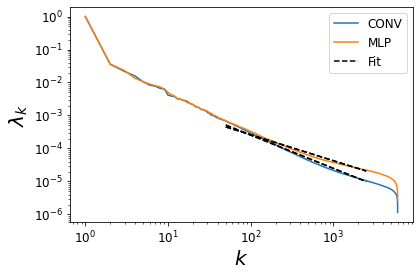

[1.008635010215918, 0.7868183179574973]


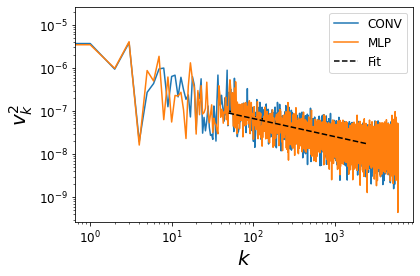

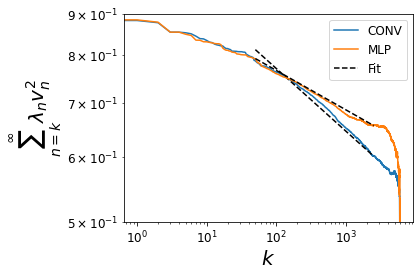

[0.07671703648705944, 0.0482533345423585]


In [ ]:
def extract_power_law(spec, start=0, end=None, xarr = []):
  if end == None:
    end = len(spec)
  inds= np.linspace(start, end, end - start) 
  if len(xarr) > 0:
    inds = xarr[start:end]
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta

labels = ['CONV', 'MLP']
all_b = []
start = 50
end = 2500

for i,eigs in enumerate(all_eigs):
  b_i = extract_power_law( eigs, start,end)
  eig_i = eigs/eigs[0]
  
  pred =  np.linspace(start,end, end-start)**(-b_i)
  pred = pred * np.mean(eig_i[start:end]) /  np.mean(pred)
  plt.loglog( np.linspace(1,len(all_eigs[i]), len(all_eigs[i])), eig_i , label = labels[i])
  plt.loglog( np.linspace(start, end, end-start), pred  , '--', color = 'black')
  if i == len(all_v)-1:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black', label = 'Fit' )
  else:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )

  all_b += [b_i]
plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\lambda_k$',fontsize =20)
#plt.title('Kernel Eigenvalues', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'cifar_conv_vs_MLP_spectra_scaling_exponents.pdf')
plt.show()
print(all_b)

all_a = []

for i, v in enumerate(all_v): 
  plt.loglog(v, label = labels[i])
  a_i = extract_power_law( v, start,end)
  all_a += [a_i]
  pred = np.linspace(start,end, end-start)**(-a_i)
  pred = pred/np.mean(pred) * np.mean(v[start:end])
  if i == len(all_v)-1:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black', label = 'Fit' )
  else:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )

plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$v_k^2$',fontsize =20)
#plt.title('Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'cifar_conv_vs_MLP_task_scaling_exponents.pdf')
plt.show()


all_a2 = []
for i, v in enumerate(all_v): 
  cum_v = np.cumsum(v) / np.sum(v)
  acumv = ( 1-cum_v ) * len(cum_v) / (10+len(cum_v) - np.linspace(1,len(cum_v), len(cum_v)))
  a_i = extract_power_law( acumv, start,end)
  all_a2 += [a_i]
  pred = np.linspace(start,end, end-start)**(-a_i)
  pred = pred/np.mean(pred) * np.mean(1-cum_v[start:end])
  pred = pred * acumv[end] / pred[-1]
  plt.loglog(acumv, label = labels[i])

  if i == len(all_v)-1:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black', label = 'Fit' )
  else:
    plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )


plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\sum_{n=k}^\infty \lambda_n v_n^2 $',fontsize =20)
plt.ylim([0.5,0.9])
#plt.title('Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'cifar_conv_vs_MLP_task_scaling_exponents_tailsum_better_title.pdf')
plt.show()
print(all_a2)



In [ ]:
import timeit
def train_model(params, apply_fn, learning_rate=0.001, batch_size = 25, num_step = 2500, conv=True):

  
  loss = jit( lambda params, Xtr, ytr: 10*jnp.mean(  ( apply_fn(params, Xtr) - ytr)**2  ) )
  test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, image_test[0:500,:,:,:]) - y_mat_te[0:500,:])**2  ) )
  if conv == False:
    test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, Xte[0:500,:]) - y_mat_te[0:500,:])**2  ) )

  grad_fn  = jit(grad(loss, 0))
  
  opt_init, opt_update, get_params = optimizers.adam(learning_rate)
  opt_state = opt_init(params)
  train = []
  test = []
  start = timeit.default_timer()
  for t in range(num_step):
    start = (batch_size * t) % 50000
    if conv == True:
      D_t = image[start:start+batch_size,:,:,:]
    else:
      D_t = X[start:start+batch_size,:]
    y_t = y_mat[start:start+batch_size,:]
    opt_state = opt_update(t, grad_fn(get_params(opt_state), D_t, y_t) , opt_state)
    #train_loss = loss(get_params(opt_state),  D_t, y_t )
    #train += [train_loss]

    #wandb.log({'train-loss': np.array(train_loss), 'test-loss': np.array(test_loss(get_params(opt_state))) })
    if t % 100 == 0:
      test  += [test_loss(get_params(opt_state))]
      sys.stdout.write('\r t = %d | train: %0.4f | test = %0.4f' % (t, loss(get_params(opt_state),  D_t, y_t ), test[-1]))
      
  return train, test

### Train MLP and Conv net to compare

In [ ]:
width = 512
num_step = 12000
init_fn, apply_fn, _ = fully_connected(width, depth)
_, params= init_fn(random.PRNGKey(0), (-1, 3*32**2))
train_mlp, test_mlp = train_model(params, apply_fn, num_step = num_step, conv=False)

 t = 11900 | train: 0.6793 | test = 0.7022

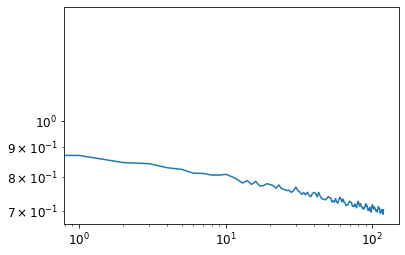

In [ ]:
plt.loglog(test_mlp)
plt.show()

In [ ]:
width = 50
num_step = 12000
print(image_test.shape)
print(image.shape)
init_fn, apply_fn, _ = convnet(width, depth)
_, params= init_fn(random.PRNGKey(0), (-1, 32,32,3))
train_conv, test_conv = train_model(params, apply_fn, learning_rate = 0.01, num_step = num_step, conv=True)

(10000, 32, 32, 3)
(50000, 32, 32, 3)
 t = 11900 | train: 0.6083 | test = 0.5745

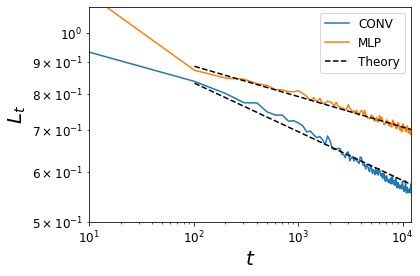

In [ ]:
start = 1
end = 12000
arr = np.linspace(start, end, len(test_conv))

plt.loglog(arr, test_conv, label = labels[0])
plt.loglog(arr, test_mlp, label = labels[1])

scale_1 = arr**(-all_a2[0])
scale_1 = scale_1 / scale_1[-1] * test_conv[-1]

scale_2 = arr**(-all_a2[1])
scale_2 = scale_2 / scale_2[-1] * test_mlp[-1]
plt.loglog(arr[1:], scale_1[1:], '--',color = 'black', label = 'Theory')
plt.loglog(arr[1:], scale_2[1:], '--', color = 'black')
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$L_t$',fontsize=20)
plt.ylim([5e-1,1.1])
plt.xlim([10,np.amax(arr)])
#plt.title('CIFAR Online Scalings',fontsize=20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'wide_conv_vs_mlp_cifar_longer.pdf')
plt.show()

In [ ]:
image = image.transpose((0,2,3,1))
image_test = image_test.transpose((0,2,3,1))

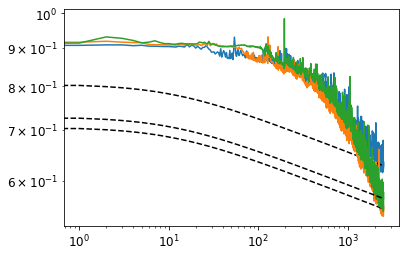

In [ ]:
for i, w in enumerate(all_widths):
  plt.loglog(all_test[i][10:], label = 'width=%d' % w)
  arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(-all_a2[0])
  arr = arr / arr[-1] * all_test[i][-1]
  plt.loglog(arr[10:],'--', color = 'black' )

plt.show()

In [ ]:
print( get_run_name(config) )


width_500_depth_5_wscale_1_lr_0.05_batch_50_Myrtle_CIFAR-10


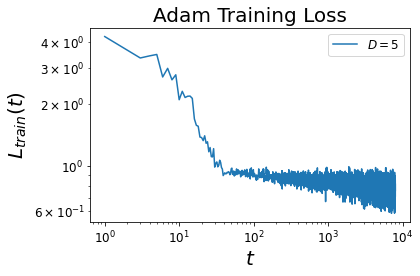

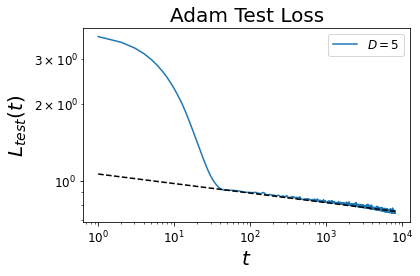

In [ ]:
def extract_power_law(spec, start=0, end=None):
  if end == None:
    end = len(spec)
  inds= np.linspace(start, end, end - start) 
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta



for i,d in enumerate(depth_vals):
  
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), all_train[i], label = r'$D = %d$' % d)
  arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(-all_a2[i])
  arr = arr / arr[-1] * all_train[i][-1]
  #plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), arr, '--', color = 'black')

#plt.semilogy(losses[0] * jnp.linspace(1,100,100)**(- 0.1 ), '--', color ='black',  label = r'$(a-1)/b$')
plt.title('Adam Training Loss', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{train}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'train_scalings_depth.pdf')
plt.show()


all_beta = []
for i, d in enumerate(depth_vals):
  #beta_i = extract_power_law(all_train[i], 10, 500)
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), all_test[i], label = r'$D=%d$' % d)
  arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(-all_a2[i])
  arr = arr / arr[-1] * all_test[i][-1]
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), arr, '--', color = 'black')
  #pred = np.linspace(10, 500, 490)**(-beta_i)
  #pred = pred* all_train[i][-1] / pred[-1]
  #plt.loglog( np.linspace(10, 500, 490), pred , '--', color = 'black' )
  #all_beta += [beta_i]
plt.title('Adam Test Loss', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{test}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'test_scalings_depth.pdf')
#plt.loglog(test[0] * jnp.linspace(1, len(test), len(test))**(-0.3), '--', color = 'black')
plt.show()


#print(all_beta)

#all_pred_beta= []
#for i, d in enumerate(depth_vals):
#  all_pred_beta += [ (all_a[i]-1) / (1.5*all_b[i]) ]
#beta_grid = np.linspace(0, 0.7, 100)
#plt.scatter(all_pred_beta, all_beta)
#plt.plot(beta_grid, beta_grid, color = 'black' )
#plt.show()


## Offline Kernel Regression Scalings

Theoretical calculation shows that, for offline kernel regression $\lambda_k \sim k^{-b}$ and 



0.3254453621649234
0.3393663156896242
0.33202795267991236


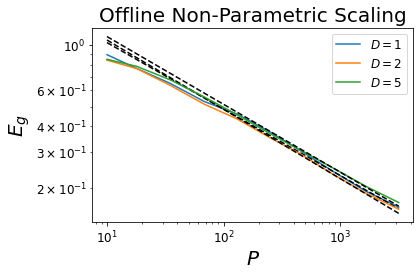

In [ ]:
def kernel_reg_expt(K, Ktr_te, y, y_te, Pvals, lamb = 1e-3):

  num_rep = 10
  all_errs = np.zeros((len(Pvals), num_rep))
  for i,P in enumerate(Pvals):

    for j in range(num_rep):
      inds = np.random.randint(0, K.shape[0], size = P )
      ki = K[inds,:]
      kii= ki[:,inds]
      k_tr_test = Ktr_te[inds,:]
      alpha =  jnp.linalg.inv( kii + lamb* np.eye(P)) @   y[inds,:] 
      yhat = k_tr_test.T @ alpha
      all_errs[i,j] = 10*jnp.mean( (yhat - y_te)**2 )
  return all_errs.mean(axis = 1)

Pvals = np.logspace(1, 3.5, num = 10).astype('int')
for i, K in enumerate(all_K):
  all_errs = kernel_reg_expt(K, all_K_te[i], y_mat[0:5000,:], y_mat_te[0:1000,:], Pvals)
  plt.loglog(Pvals, all_errs, label = '$D = %d$' % depth_vals[i])
  #beta_i = min( all_a[i]-1, 2*all_b[i] )
  arr = Pvals**(-  all_a[i] + 1)
  arr = arr / arr[-1] * all_errs[-1]
  #beta_hat = extract_power_law(spec=all_errs, start = 5, end = 15, xarr = Pvals)
  beta_hat = all_a2[i]
  arr = Pvals**(-beta_hat)
  arr = arr / arr[7] * all_errs[7]
  print(beta_hat)
  plt.loglog(Pvals, arr, '--', color = 'black')
  #plt.loglog(Pvals, Pvals**( 1 - all_a[i] ), '--', color = 'black' )

plt.xlabel(r'$P$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.legend()

plt.title('Offline Non-Parametric Scaling', fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'offline_kernel_reg_scaling.pdf')
plt.show()



### Offline Neural Network Generalization

Training a wide but finite (width 5000) neural network gives the same scaling. 

P = 10
0.6381308
0.19417307
0.116507165
0.043257352
0.0359007
0.017131211
0.010057815
0.006210867
0.0028104384
0.0023756742
0.0012217074
0.0011480226
0.00035719224
0.00029778096
0.00018177307
0.00012386995
4.8729657e-05
4.6926965e-05
2.1761281e-05
1.3183833e-05
TEST LOSS
1.017123
P = 13
0.7703501
0.13844489
0.12583825
0.043813776
0.036042243
0.015520248
0.011789321
0.0069431304
0.0033869904
0.0031266552
0.0012118843
0.0010675245
0.0004362504
0.00032145387
0.00016206405
0.00013325019
6.5815504e-05
3.7631387e-05
2.4292623e-05
1.53801e-05
TEST LOSS
0.92092746
P = 18
0.6878409
0.14456432
0.08238654
0.048747428
0.035626013
0.025255157
0.01751087
0.009009219
0.004159385
0.0028186685
0.0012011671
0.00075753755
0.0004967243
0.00028319092
0.0001616487
0.00015315604
6.951245e-05
6.398189e-05
3.852301e-05
2.1271617e-05
TEST LOSS
0.8986084
P = 24
0.7510613
0.15962645
0.06755257
0.043520145
0.022174388
0.01668638
0.011651325
0.005921848
0.0026644524
0.0019367556
0.0014359774
0.0007195015
0.00041625

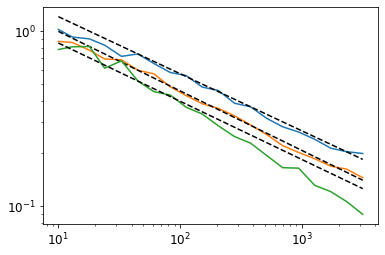

In [ ]:
width = 2500
depth_vals = [1, 2, 5]
num_repeat = 1

key = random.PRNGKey(0)
opt_init, opt_update, get_params = optimizers.adam(1e-2)

all_errs = np.zeros((len(depth_vals), len(Pvals), num_repeat))
for i, d in enumerate(depth_vals):
  init_fn, apply_fn, kernel_fn = fully_connected(width, d)
  key = random.PRNGKey(0)
  loss = jit( lambda params, Xtr, ytr: 10*jnp.mean(  ( apply_fn(params, Xtr) - ytr)**2  ) )
  test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, Xte[0:1000,:]) - y_mat_te[0:1000,:])**2  ) )
  grad_fn  = jit(grad(loss, 0))

  for j,P in enumerate(Pvals):
    print("P = %d" % P)
    for k in range(num_repeat):
      key, subkey = random.split(key)
      _, params = init_fn(subkey, (-1,784))
      inds = np.random.randint(0,X.shape[0], P)
      train_mat = X[inds,:]
      train_labels = y_mat[inds,:]
      opt_state = opt_init(params)
      for t in range(100):
        opt_state = opt_update(t, grad_fn(get_params(opt_state), train_mat, train_labels) , opt_state)
        if t % 5 == 0:
          print(loss(get_params(opt_state), train_mat, train_labels))

      print("TEST LOSS")
      test_loss_val = test_loss(get_params(opt_state))
      print(test_loss_val)
      all_errs[i,j,k] = test_loss_val


for i,d in enumerate(depth_vals):
  errs_i = all_errs[i,:,:].mean(axis =1)
  plt.loglog(Pvals,errs_i)
  beta_hat = all_a2[i]
  arr = Pvals**(-beta_hat)
  arr = arr / arr[5] * errs_i[5]
  print(beta_hat)
  plt.loglog(Pvals, arr, '--', color = 'black', label = r'$P^{-a+1}$')
plt.show()
      


0.3254453621649234
0.3393663156896242
0.33202795267991236


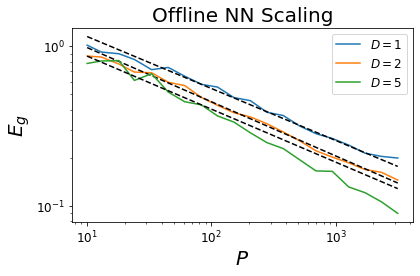

In [ ]:
for i,d in enumerate(depth_vals):
  errs_i = all_errs[i,:,:].mean(axis =1)
  plt.loglog(Pvals,errs_i, label = r'$D = %d$' % d)
  beta_hat = all_a2[i]
  arr = Pvals**(-beta_hat)
  arr = arr / arr[7] * errs_i[7]
  print(beta_hat)
  plt.loglog(Pvals, arr, '--', color = 'black')

plt.xlabel(r'$P$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.legend()
plt.title('Offline NN Scaling', fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'offline_nn_scaling.pdf')
plt.show()


In [ ]:
width = 5000
depth_vals = [1, 2, 5]

batch_size = 10

all_train = []
all_test = []

for i, d in enumerate(depth_vals):
  print("Depth: %d" % d)
  init_fn, apply_fn, kernel_fn = fully_connected(width, d)
  _, params = init_fn(random.PRNGKey(1), (-1,784))

  loss = jit( lambda params, Xtr, ytr: 10*jnp.mean(  ( apply_fn(params, Xtr) - ytr)**2  ) )
  test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, Xte[0:1000,:]) - y_mat_te[0:1000,:])**2  ) )
  grad_fn  = jit(grad(loss, 0))
  
  opt_init, opt_update, get_params = optimizers.adam(1e-3)
  opt_state = opt_init(params)

  train = []
  test = []
  for t in range(500):
    start = (batch_size * t) % 50000
    train_loss = loss(get_params(opt_state),  X[start:start+batch_size,:], y_mat[start:start+batch_size,:] )
    opt_state = opt_update(t, grad_fn(get_params(opt_state), X[start:start+batch_size,:], y_mat[start:start+batch_size,:]) , opt_state)
    if t >= 0:
      train += [train_loss]
      test  += [test_loss(get_params(opt_state))]
    else:
      train += [ t/(t+1) * train[-1] + 1/(t+1) * train_loss ]
      test += [t/(t+1) * test[-1] + 1/(1+t) * test_loss(get_params(opt_state))]

    #sys.stdout(loss(get_params(opt_state)))
    if t % 25 ==0:
      print(train[-1])
  all_train += [train]
  all_test += [test]


Depth: 1
1.6214751
0.98410505
0.8358611
0.60497504
0.66764015
0.5811716
0.61639905
0.598087
0.4140371
0.46534526
0.46412745
0.37387902
0.48379084
0.2313381
0.42022192
0.4085883
0.4240083
0.37023574
0.3052946
0.33928293
Depth: 2
1.2398272
0.59266275
0.41719487
0.3352655
0.53177184
0.48600605
0.46171337
0.33476087
0.3310471
0.36756575
0.3437593
0.22943062
0.31863534
0.1664831
0.33743468
0.354016
0.31023443
0.3591829
0.25506586
0.1767648
Depth: 5
0.9997887
0.5707317
0.3961634
0.32188514
0.44987658
0.4550103
0.37806672
0.32084817
0.27924842
0.3042961
0.32338956
0.17369066
0.24928178
0.10126067
0.31283256
0.3239386
0.23061731
0.2524881
0.1586975
0.10463907


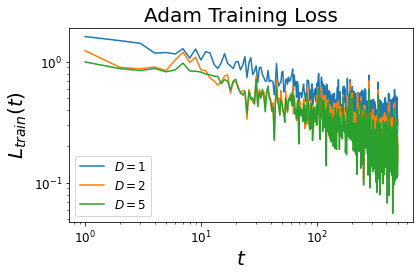

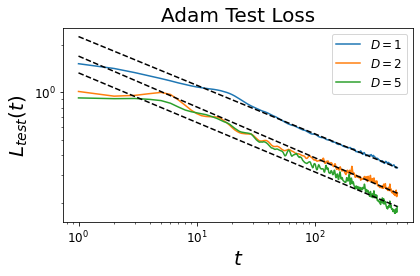

In [ ]:
def extract_power_law(spec, start=0, end=None):
  if end == None:
    end = len(spec)
  inds= np.linspace(start, end, end - start) 
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta



for i,d in enumerate(depth_vals):
  
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), all_train[i], label = r'$D = %d$' % d)
  arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(-all_a2[i])
  arr = arr / arr[-1] * all_train[i][-1]
  #plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), arr, '--', color = 'black')

#plt.semilogy(losses[0] * jnp.linspace(1,100,100)**(- 0.1 ), '--', color ='black',  label = r'$(a-1)/b$')
plt.title('Adam Training Loss', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{train}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'train_scalings_depth.pdf')
plt.show()


all_beta = []
for i, d in enumerate(depth_vals):
  #beta_i = extract_power_law(all_train[i], 10, 500)
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), all_test[i], label = r'$D=%d$' % d)
  arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(-all_a2[i])
  arr = arr / arr[-1] * all_test[i][-1]
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), arr, '--', color = 'black')
  #pred = np.linspace(10, 500, 490)**(-beta_i)
  #pred = pred* all_train[i][-1] / pred[-1]
  #plt.loglog( np.linspace(10, 500, 490), pred , '--', color = 'black' )
  #all_beta += [beta_i]
plt.title('Adam Test Loss', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{test}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'test_scalings_depth.pdf')
#plt.loglog(test[0] * jnp.linspace(1, len(test), len(test))**(-0.3), '--', color = 'black')
plt.show()


#print(all_beta)

#all_pred_beta= []
#for i, d in enumerate(depth_vals):
#  all_pred_beta += [ (all_a[i]-1) / (1.5*all_b[i]) ]
#beta_grid = np.linspace(0, 0.7, 100)
#plt.scatter(all_pred_beta, all_beta)
#plt.plot(beta_grid, beta_grid, color = 'black' )
#plt.show()


In [ ]:
all_test_np = np.array(all_test)
all_train_np = np.array(all_train)
np.savetxt(root_dir + 'all_test_online_data.txt', all_test_np)
np.savetxt(root_dir + 'all_train_online_data.txt', all_train_np)


## Compare Adam result to vanilla SGD


In [ ]:
width = 5000
depth_vals = [1, 2, 5]

batch_size = 10

all_train_sgd = []
all_test_sgd = []

for i, d in enumerate(depth_vals):
  print("Depth: %d" % d)
  init_fn, apply_fn, kernel_fn = fully_connected(width, d)
  _, params = init_fn(random.PRNGKey(1), (-1,784))

  loss = jit( lambda params, Xtr, ytr: 10*jnp.mean(  ( apply_fn(params, Xtr) - ytr)**2  ) )
  test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, Xte[0:1000,:]) - y_mat_te[0:1000,:])**2  ) )
  grad_fn  = jit(grad(loss, 0))
  
  opt_init, opt_update, get_params = optimizers.sgd(10)
  opt_state = opt_init(params)

  train = []
  test = []
  for t in range(1000):
    start = (batch_size * t) % 50000
    train_loss = loss(get_params(opt_state),  X[start:start+batch_size,:], y_mat[start:start+batch_size,:] )
    opt_state = opt_update(t, grad_fn(get_params(opt_state), X[start:start+batch_size,:], y_mat[start:start+batch_size,:]) , opt_state)
    if t >= 0:
      train += [train_loss]
      test  += [test_loss(get_params(opt_state))]
    else:
      train += [ t/(t+1) * train[-1] + 1/(t+1) * train_loss ]
      test += [t/(t+1) * test[-1] + 1/(1+t) * test_loss(get_params(opt_state))]

    #sys.stdout(loss(get_params(opt_state)))
    if t % 25 ==0:
      print(train[-1])
  all_train_sgd += [train]
  all_test_sgd += [test]


Depth: 1
1.3284107
0.6946377
0.8131082
0.47096354
0.38937622
0.49847433
0.43452474
0.32984734
0.27174532
0.4864631
0.42856246
0.3143985
0.41328943
0.34423134
0.35825032
0.26011914
0.315856
0.5811706
0.28309432
0.2502434
0.40393227
0.28489068
0.26641688
0.25709575
0.29636946
0.36860782
0.46081975
0.284861
0.36991018
0.16843262
0.45413426
0.35079712
0.17349373
0.17864071
0.23012203
0.37427503
0.26405036
0.2702474
0.36170894
0.23244496
Depth: 2
1.0878876
0.71667886
0.7339418
0.49778855
0.33943173
0.3933229
0.4042931
0.29983976
0.2530414
0.37878737
0.3971786
0.3058723
0.35987934
0.32881248
0.35228086
0.24002114
0.26755342
0.5491675
0.24702372
0.23650211
0.36424863
0.23309125
0.21779794
0.2812576
0.2728655
0.31219807
0.45208147
0.26144394
0.32331845
0.15124446
0.4162959
0.3764946
0.15931334
0.157961
0.19825207
0.30034488
0.21390122
0.268135
0.34663418
0.21386181
Depth: 5
0.9471305
0.84751487
0.76798546
0.68539447
0.6183326
0.5860371
0.5491285
0.4812835
0.32830828
0.45380852
0.4931952
0.4316

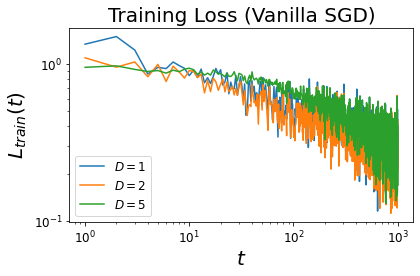

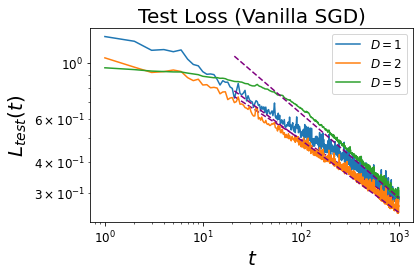

In [ ]:
def extract_power_law(spec, start=0, end=None):
  if end == None:
    end = len(spec)
  inds= np.linspace(start, end, end - start) 
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta


for i,d in enumerate(depth_vals):
  
  plt.loglog(np.linspace(1,len(all_train_sgd[i]),len(all_train_sgd[i])), all_train_sgd[i], label = r'$D = %d$' % d)
  arr = np.linspace(1,len(all_train_sgd[i]),len(all_train_sgd[i]))**(-all_a2[i]/all_b[i])
  arr = arr / arr[-1] * all_train_sgd[i][-1]
  #plt.loglog(np.linspace(1,len(all_train_sgd[i]),len(all_train_sgd[i]))[20:], arr[20:], '--', color = 'blue')

#plt.semilogy(losses[0] * jnp.linspace(1,100,100)**(- 0.1 ), '--', color ='black',  label = r'$(a-1)/b$')
plt.title('Training Loss (Vanilla SGD)', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{train}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'train_scalings_depth_vanilla_sgd.pdf')
plt.show()


all_beta = []
for i, d in enumerate(depth_vals):
  #beta_i = extract_power_law(all_train[i], 10, 500)
  plt.loglog(np.linspace(1,len(all_train_sgd[i]),len(all_train_sgd[i])), all_test_sgd[i], label = r'$D=%d$' % d)
  arr = np.linspace(1,len(all_train_sgd[i]),len(all_train_sgd[i]))**(-all_a2[i]/all_b[i])
  arr = arr / arr[-1] * all_test_sgd[i][-1]
  plt.loglog(np.linspace(1,len(all_train_sgd[i]),len(all_train_sgd[i]))[20:], arr[20:], '--', color = 'purple')
  #arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(-all_a2[i]/all_b[i])
  #arr = arr / arr[-1] * all_test_sgd[i][-1]
  #plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), arr, '--', color = 'blue')
  #pred = np.linspace(10, 500, 490)**(-beta_i)
  #pred = pred* all_train[i][-1] / pred[-1]
  #plt.loglog( np.linspace(10, 500, 490), pred , '--', color = 'black' )
  #all_beta += [beta_i]
plt.title('Test Loss (Vanilla SGD)', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{test}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'test_scalings_depth_vanilla_sgd.pdf')
#plt.loglog(test[0] * jnp.linspace(1, len(test), len(test))**(-0.3), '--', color = 'black')
plt.show()


#print(all_beta)

#all_pred_beta= []
#for i, d in enumerate(depth_vals):
#  all_pred_beta += [ (all_a[i]-1) / (1.5*all_b[i]) ]
#beta_grid = np.linspace(0, 0.7, 100)
#plt.scatter(all_pred_beta, all_beta)
#plt.plot(beta_grid, beta_grid, color = 'black' )
#plt.show()


## Repeat for Convolution

In [ ]:
width = 5000
depth_vals = [1,2,5]

all_eigs = []
all_v = []
all_K = []
all_K_te = []
image = jnp.array(image, dtype = jnp.float32)
image_test = jnp.array(image_test, dtype = jnp.float32)
print(image.shape)
for i, d in enumerate(depth_vals):
  init_fn, apply_fn, kernel_fn = convnet(width, d, pool = False)
  batch_kern = nt.batch(kernel_fn, batch_size=500)
  K = batch_kern(image[0:5000,:,:,:], image[0:5000,:,:,:], get='ntk')
  K_tr_test = batch_kern(image[0:5000,:,:,:], image_test[0:1000,:,:,:], 'ntk')
  all_K += [K]
  all_K_te += [K_tr_test]

  eigs, vec = jnp.linalg.eigh(K)


  v = jnp.sum( ( 1/vec.shape[0] * vec.T @ y_mat[0:5000,:])**2 , axis = 1)
  indsort = jnp.argsort(eigs)[::-1]


  all_eigs += [ eigs[indsort] ]
  all_v += [ v[indsort] ]


(50000, 1, 28, 28)


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5293: Use

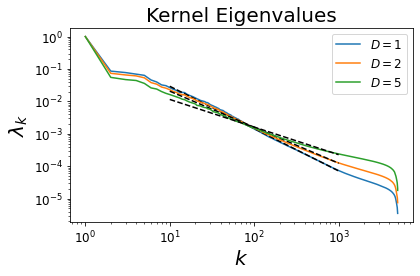

[1.3051938380486265, 1.1112336245489558, 0.8517922750148305]


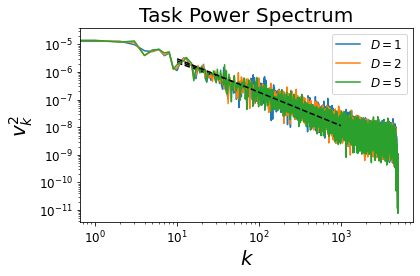

[1.0452798679121837, 1.1189664286964833, 1.2122212774236434]


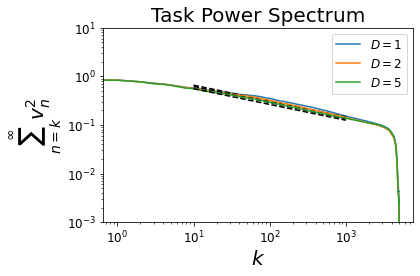

[0.32738867880964573, 0.3336388407041368, 0.32454987430415294]


In [ ]:
def extract_power_law(spec, start=0, end=None, xarr = []):
  if end == None:
    end = len(spec)
  inds= np.linspace(start, end, end - start) 
  if len(xarr) > 0:
    inds = xarr[start:end]
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta

all_b = []
start = 10
end = 1000
for i,d in enumerate(depth_vals):
  b_i = extract_power_law( all_eigs[i], start,end)
  eig_i = all_eigs[i]/all_eigs[i][0]
  plt.loglog( np.linspace(1,len(all_eigs[i]), len(all_eigs[i])), eig_i , label = r'$D = %d$' % d)
  pred =  np.linspace(start,end, end-start)**(-b_i)
  pred = pred * np.mean(eig_i[start:end]) /  np.mean(pred)
  plt.loglog( np.linspace(start, end, end-start), pred  , '--', color = 'black')
  all_b += [b_i]
plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\lambda_k$',fontsize =20)
plt.title('Kernel Eigenvalues', fontsize = 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'mnist_conv_spectra_scaling_exponents_depth.pdf')
plt.show()
print(all_b)

all_a = []
for i, d in enumerate(depth_vals): 
  plt.loglog(all_v[i], label = r'$D = %d$' % d)
  a_i = extract_power_law( all_v[i], start,end)
  all_a += [a_i]
  pred = np.linspace(start,end, end-start)**(-a_i)
  pred = pred/np.mean(pred) * np.mean(all_v[i][start:end])
  plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )

plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$v_k^2$',fontsize =20)
plt.title('Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'mnist_conv_task_scaling_exponents_depth.pdf')
plt.show()

print(all_a)

all_a2 = []
for i, d in enumerate(depth_vals): 
  cum_v = np.cumsum(all_v[i]) / np.sum(all_v[i])
  cum_adj = (1-cum_v) * len(cum_v)/(10+len(cum_v)-np.linspace(1,len(cum_v), len(cum_v)))
  plt.loglog(cum_adj, label = r'$D = %d$' % d)
  a_i = extract_power_law( cum_adj, start,end)
  all_a2 += [a_i]
  pred = np.linspace(start,end, end-start)**(-a_i)
  pred = pred/np.mean(pred) * np.mean(1-cum_v[start:end])
  plt.loglog( np.linspace(start,end, end-start), pred, '--', color = 'black' )

plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\sum_{n=k}^\infty v_n^2 $',fontsize =20)
plt.ylim([1e-3,10])
plt.title('Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.savefig(root_dir + 'mnist_conv_task_scaling_exponents_depth_tailsum.pdf')
plt.show()
print(all_a2)

In [ ]:
def train_conv_net(apply_fn, params, lr, opt_type = 'sgd', gamma = None, batch_size = 10, steps = 800):

  loss = jit( lambda params, Xtr, ytr: 10*jnp.mean(  ( apply_fn(params, Xtr) - ytr)**2  ) )
  test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, image_test[0:1000,:]) - y_mat_te[0:1000,:])**2  ) )
  grad_fn  = jit(grad(loss, 0))
  
  if gamma != None:
    opt_init, opt_update, get_params = optimizers.sgd(lambda t: lr * (t+1)**(gamma))
  elif opt_type == 'adam':
    opt_init, opt_update, get_params = optimizers.adam(1e-3)
  else:
    opt_init, opt_update, get_params = optimizers.sgd(lr)

  opt_state = opt_init(params)

  train = []
  test = []
  for t in range(steps):
    start = (batch_size * t) % 50000
    train_loss = loss(get_params(opt_state),  image[start:start+batch_size,:,:,:], y_mat[start:start+batch_size,:] )
    opt_state = opt_update(t, grad_fn(get_params(opt_state), image[start:start+batch_size,:,:,:], y_mat[start:start+batch_size,:]) , opt_state)
    if t >= 0:
      train += [train_loss]
      test  += [test_loss(get_params(opt_state))]
    else:
      train += [ t/(t+1) * train[-1] + 1/(t+1) * train_loss ]
      test += [t/(t+1) * test[-1] + 1/(1+t) * test_loss(get_params(opt_state))]

    #sys.stdout(loss(get_params(opt_state)))
    if t % 25 ==0:
      print("train: %0.2f | test: %0.2f" %(train[-1], test[-1]) )
  return train, test

In [ ]:
width = 2500
depth_vals = [1, 2, 5]
#depth_vals = [5]
batch_size = 10

all_train = []
all_test = []
key = random.PRNGKey(1)
print(all_eigs[0][0])
print(all_eigs[1][0])
print(all_eigs[2][0])
for i, d in enumerate(depth_vals):
  print("Depth: %d" % d)
  init_fn, apply_fn, kernel_fn = convnet(width, d, pool = False)
  _, params = init_fn(random.PRNGKey(1), (-1,1,28,28))

  train, test = train_conv_net(apply_fn, params, lr = 100/all_eigs[i][0])

  all_train += [train]
  all_test += [test]


80.350655
19.58543
0.16818689
Depth: 1
train: 1.02 | test: 1.21
train: 1.04 | test: 1.00
train: 0.97 | test: 0.92
train: 0.87 | test: 0.87
train: 0.92 | test: 0.84
train: 0.75 | test: 0.81
train: 0.80 | test: 0.77
train: 0.76 | test: 0.75
train: 0.60 | test: 0.73
train: 0.67 | test: 0.71
train: 0.58 | test: 0.69
train: 0.72 | test: 0.67
train: 0.64 | test: 0.66
train: 0.63 | test: 0.65
train: 0.74 | test: 0.63
train: 0.56 | test: 0.62
train: 0.63 | test: 0.61
train: 0.74 | test: 0.60
train: 0.64 | test: 0.59
train: 0.68 | test: 0.59
train: 0.52 | test: 0.58
train: 0.56 | test: 0.57
train: 0.56 | test: 0.56
train: 0.56 | test: 0.56
train: 0.56 | test: 0.55
train: 0.55 | test: 0.55
train: 0.47 | test: 0.54
train: 0.61 | test: 0.54
train: 0.54 | test: 0.53
train: 0.44 | test: 0.53
train: 0.59 | test: 0.53
train: 0.53 | test: 0.52
Depth: 2
train: 1.05 | test: 1.01
train: 0.87 | test: 0.89
train: 0.88 | test: 0.84
train: 0.80 | test: 0.80
train: 0.75 | test: 0.77
train: 0.74 | test: 0.74
tr

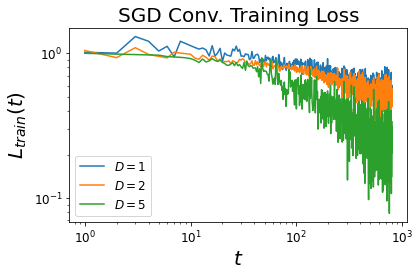

1.3051938380486265
1.1112336245489558
0.8517922750148305


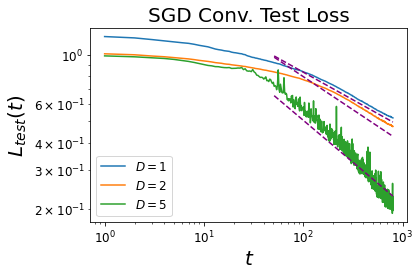

In [ ]:
def extract_power_law(spec, start=0, end=None):
  if end == None:
    end = len(spec)
  inds = np.linspace(start, end, end - start) 
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta

depth_vals = [1,2,5]

for i,d in enumerate(depth_vals):
  
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), all_train[i], label = r'$D = %d$' % d)
  arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(-all_a2[i])
  arr = arr / arr[-1] * all_train[i][-1]
  #plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), arr, '--', color = 'black')

#plt.semilogy(losses[0] * jnp.linspace(1,100,100)**(- 0.1 ), '--', color ='black',  label = r'$(a-1)/b$')
plt.title('SGD Conv. Training Loss', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{train}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'train_conv_vanillasgd_scalings_depth.pdf')
plt.show()


all_beta = []
for i, d in enumerate(depth_vals):
  #beta_i = extract_power_law(all_train[i], 10, 500)
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), all_test[i], label = r'$D=%d$' % d)
for i, d in enumerate(depth_vals):
  bi = all_b[i]
  print(bi)
  arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(-all_a2[i]/bi)
  arr = arr / np.mean(arr) * np.mean(all_test[i])
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i]))[50:], arr[50:], '--', color = 'purple')
  #pred = np.linspace(10, 500, 490)**(-beta_i)
  #pred = pred* all_train[i][-1] / pred[-1]
  #plt.loglog( np.linspace(10, 500, 490), pred , '--', color = 'black' )
  #all_beta += [beta_i]
plt.title('SGD Conv. Test Loss', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{test}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'test_conv_vanillasgd_scalings_depth.pdf')
#plt.loglog(test[0] * jnp.linspace(1, len(test), len(test))**(-0.3), '--', color = 'black')
plt.show()


#print(all_beta)

#all_pred_beta= []
#for i, d in enumerate(depth_vals):
#  all_pred_beta += [ (all_a[i]-1) / (1.5*all_b[i]) ]
#beta_grid = np.linspace(0, 0.7, 100)
#plt.scatter(all_pred_beta, all_beta)
#plt.plot(beta_grid, beta_grid, color = 'black' )
#plt.show()


In [ ]:
all_test_np = np.array(all_test)
all_train_np = np.array(all_train)
np.savetxt(root_dir + 'all_test_conv_online_data.txt', all_test_np)
np.savetxt(root_dir + 'all_train_conv_online_data.txt', all_train_np)


## Learning Rate Schedule

If $\eta(t) \sim t^{\gamma-1}$ then $L_t \sim t^{- \frac{\gamma}{b} (a-1)}$. Infinite width theory predicts exponent altered by a factor of $\gamma$. Is this true?

In [ ]:
d = 1
gamma_vals = [-0.5, 0.0, 0.5, 0.75]
all_train = []
all_test = []
for gamma in gamma_vals:
  print("GAMMA")
  print(gamma)
  init_fn, apply_fn, kernel_fn = convnet(2000, d, pool = False)
  _, params = init_fn(random.PRNGKey(1), (-1,1,28,28))

  train, test = train_conv_net(apply_fn, params, lr = 500/all_eigs[0][0], gamma = gamma)
  all_train += [train]
  all_test += [test]

GAMMA
-0.5
train: 1.02 | test: 1.19
train: 0.99 | test: 0.95
train: 0.95 | test: 0.90
train: 0.86 | test: 0.87
train: 0.92 | test: 0.85
train: 0.77 | test: 0.83
train: 0.84 | test: 0.82
train: 0.82 | test: 0.81
train: 0.70 | test: 0.80
train: 0.74 | test: 0.79
train: 0.68 | test: 0.78
train: 0.81 | test: 0.77
train: 0.76 | test: 0.76
train: 0.74 | test: 0.75
train: 0.82 | test: 0.75
train: 0.71 | test: 0.74
train: 0.75 | test: 0.74
train: 0.82 | test: 0.73
train: 0.78 | test: 0.73
train: 0.77 | test: 0.72
train: 0.66 | test: 0.72
train: 0.72 | test: 0.71
train: 0.72 | test: 0.71
train: 0.71 | test: 0.70
train: 0.69 | test: 0.70
train: 0.68 | test: 0.70
train: 0.67 | test: 0.69
train: 0.72 | test: 0.69
train: 0.69 | test: 0.69
train: 0.63 | test: 0.68
train: 0.68 | test: 0.68
train: 0.69 | test: 0.68
GAMMA
0.0
train: 1.02 | test: 1.19
train: 0.85 | test: 0.84
train: 0.76 | test: 0.69
train: 0.64 | test: 0.62
train: 0.63 | test: 0.58
train: 0.51 | test: 0.55
train: 0.50 | test: 0.53
trai

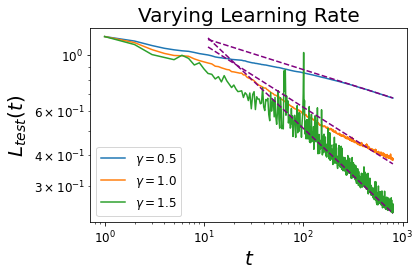

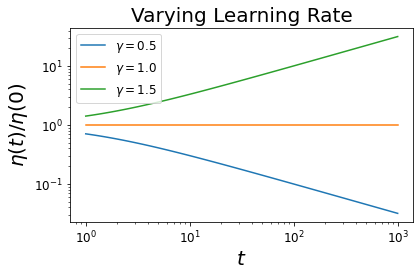

In [ ]:


for i, gamma in enumerate(gamma_vals[0:3]):
  #beta_i = extract_power_law(all_train[i], 10, 500)
  plt.loglog(np.linspace(1,len(all_train[i]),len(all_train[i])), all_test[i], label = r'$\gamma=%0.1f$' % (1+gamma))
  
for i, gamma in enumerate(gamma_vals[0:3]):
  arr = np.linspace(1,len(all_train[i]),len(all_train[i]))**(- (1+gamma)/all_b[0] * all_a2[0])
  arr = arr / arr[-300]  * all_test[i][-300]
  plt.loglog(np.linspace(1,len(arr), len(arr))[10:], arr[10:], '--', color = 'purple')

plt.title('Varying Learning Rate', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L_{test}(t)$', fontsize = 20)
plt.tight_layout()
plt.legend()
plt.savefig(root_dir + 'test_varying_lr.pdf')
plt.show()

tvals = np.logspace(0, 3, 100)
for i, gamma in enumerate(gamma_vals[0:3]):
  schedule = lambda t: (t+1)**(gamma)
  plt.loglog(tvals, schedule(tvals), label = r'$\gamma=%0.1f$' % (1+gamma))
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$\eta(t)/ \eta(0)$', fontsize = 20)
plt.legend()
plt.title('Varying Learning Rate',fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'lr_time_series.pdf')
plt.show()

### Image Jitter and Invariance

Streaming output truncated to the last 5000 lines.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264

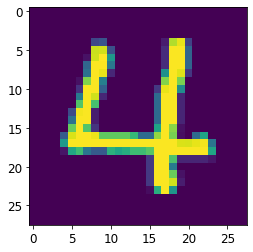

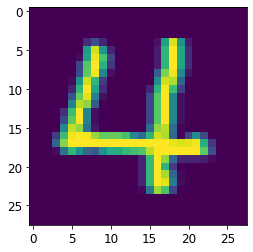

(5000, 1, 28, 28)
(10000, 28, 28, 1)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
2

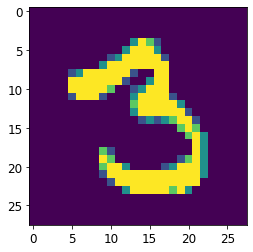

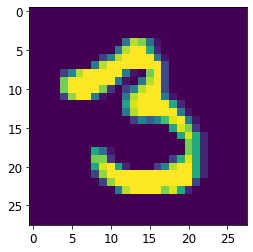

In [ ]:
from tensorflow.keras import preprocessing
#from tensorflow.keras.layers.experimental import preprocessing
image_jitter = np.zeros( (5000, image.shape[1], image.shape[2], image.shape[3]) )
image_test_jitter = np.zeros( (1000, image.shape[1], image.shape[2], image.shape[3]) )
# Download MNIST
num_tot = 50000
num_classes = 10
name = 'mnist'
ds = tfds.load(name, split=tfds.Split.TRAIN).shuffle(1024).batch(num_tot)

plt.rcParams.update({'font.size': 12})

for i,ex in enumerate(ds):
  Xtf = ex['image']
  image = Xtf.numpy() / 255.0
  X = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]*image.shape[3]))
  image = image.transpose((0,3,1,2))
  y = ex['label'].numpy()
  y_mat = np.eye(10)[y]
  break
print(Xtf.shape)

for i in range(5000):
  xi = Xtf[i,:,:,:] 
  print(i)
  image_jitter[i,:,:,:] = preprocessing.image.random_shift(xi, 0.2,0.2, fill_mode='wrap').transpose((2,0,1)) / 255.0


plt.imshow(image[0,0,:,:])
plt.show()
plt.imshow(image_jitter[0,0,:,:])
plt.show()

print(image_jitter.shape)

X_jitter = image_jitter.reshape((image_jitter.shape[0], 28*28))

ds = tfds.load(name, split=tfds.Split.TEST).shuffle(1024).batch(num_tot)

for i,ex in enumerate(ds):
  Xtf_te = ex['image']
  image_test = Xtf_te.numpy() / 255.0
  print(image_test.shape)
  Xte = np.reshape(image_test, (image_test.shape[0], image_test.shape[1]*image_test.shape[2]*image_test.shape[3]))
  image_test = image_test.transpose((0,3,1,2))
  yte = ex['label'].numpy()
  y_mat_te = np.eye(10)[yte]
  break

for i in range(1000):
  xi = Xtf_te[i,:,:,:]
  #a = preprocessing.image.random_shift(xi, 0.2,0.2).transpose((2,0,1))
  print(i)
  image_test_jitter[i,:,:,:] = preprocessing.image.random_shift(xi, 0.2, 0.2, fill_mode = 'wrap').transpose((2,0,1)) / 255.0

X_test_jitter = image_test_jitter.reshape((image_test_jitter.shape[0], 28*28))

plt.imshow(image_test[0,0,:,:])
plt.show()
plt.imshow(image_test_jitter[0,0,:,:])
plt.show()


In [ ]:

d = 1
width = 1
_, _, kernel_fn_pool = convnet(width, d, pool = False)
_,_, kernel_fc = fully_connected(width, d)

data_conv = [image[0:5000,:,:,:] , image_jitter[0:5000,:,:,:]]
data_fc = [X[0:5000,:], X_jitter[0:5000,:] ]

print(image.shape)
print(image_jitter.shape)
all_eigs = []
all_vecs = []
for dset in data_conv:
  batchfn = nt.batch(kernel_fn_pool, batch_size = 500)
  K = batchfn(dset, None, 'ntk')
  eigs, vecs = jnp.linalg.eigh(K)
  indsort = jnp.argsort(eigs)[::-1]
  v = jnp.sum( ( 1/vecs.shape[0] * vecs.T @ y_mat[0:5000,:])**2 , axis = 1)
  all_eigs += [eigs[indsort]]
  all_vecs += [v[indsort]]
  
for dset in data_fc:
  print(dset.shape)
  K = kernel_fc(dset, None, 'ntk')
  eigs, vecs = jnp.linalg.eigh(K)
  indsort = jnp.argsort(eigs)[::-1]
  v = jnp.sum( ( 1/vecs.shape[0] * vecs.T @ y_mat[0:5000,:])**2 , axis = 1)
  all_eigs += [eigs[indsort]]
  all_vecs += [v[indsort]]


(50000, 1, 28, 28)
(5000, 1, 28, 28)


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


(5000, 784)
(5000, 784)


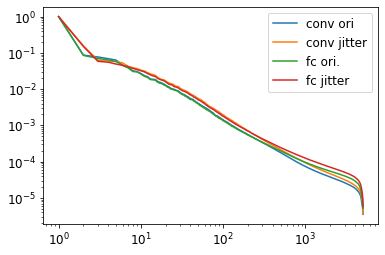

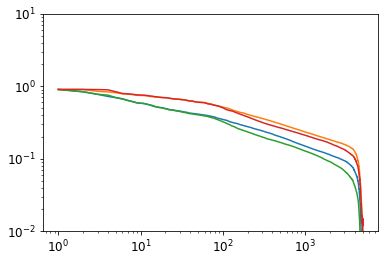

[1.3052801509074392, 1.3304916235700648, 1.1996075239999757, 1.2061200573656616]
[0.3321242828437428, 0.3078118622830518, 0.3681418380861296, 0.34279079364426074]
0.25444674280295143
0.23135197308278443
0.3068852359800113
0.28420951260272115


In [ ]:
def extract_power_law(spec, start=0, end=None):
  if end == None:
    end = len(spec)
  inds = np.linspace(start, end, end - start) 
  beta = - np.cov(np.log(inds), np.log(spec[start:end]))[0,1] / np.var(np.log(inds))
  return beta

labels = ['conv ori', 'conv jitter', 'fc ori.', 'fc jitter']
bvals_jit = []
for i, e in enumerate(all_eigs):
  bvals_jit += [ extract_power_law(e, 10,1000) ]
  plt.loglog(np.linspace(1,len(e),len(e)), e / e[0], label = labels[i])

plt.legend()
plt.show()


avals_jit = []
for i,v in enumerate(all_vecs):
  cum_v = np.cumsum(v)/np.sum(v)
  power_spec = (1-cum_v) * len(cum_v)/(len(cum_v)+10-np.linspace(1,len(cum_v), len(cum_v)) )
  avals_jit += [extract_power_law(power_spec, 10, 1000)]
  plt.loglog(np.linspace(1,len(v),len(v)), power_spec, label = labels[i])
plt.ylim([1e-2,10])
plt.show()

print(bvals_jit)
print(avals_jit)

for i, ai in enumerate(avals_jit):
  print( ai / bvals_jit[i] )

In [ ]:
def train_conv_net_dset(dset, test_dset, apply_fn, params, lr, opt_type = 'sgd', gamma = None, batch_size = 10, steps = 500, conv=True):

  loss = jit( lambda params, Xtr, ytr: 10*jnp.mean(  ( apply_fn(params, Xtr) - ytr)**2  ) )
  test_loss = jit( lambda params: 10*jnp.mean( ( apply_fn(params, test_dset) - y_mat_te[0:1000,:])**2  ) )
  grad_fn  = jit(grad(loss, 0))
  
  if gamma != None:
    opt_init, opt_update, get_params = optimizers.sgd(lambda t: lr * (t+1)**(gamma))
  elif opt_type == 'adam':
    opt_init, opt_update, get_params = optimizers.adam(lr)
  else:
    opt_init, opt_update, get_params = optimizers.sgd(lr)

  opt_state = opt_init(params)

  train = []
  test = []
  for t in range(steps):
    start = (batch_size * t) % 5000
    if conv == True:
      Dt = dset[start:start+batch_size,:,:,:]
    else:
      Dt = dset[start:start+batch_size,:]
    train_loss = loss(get_params(opt_state), Dt , y_mat[start:start+batch_size,:] )
    opt_state = opt_update(t, grad_fn(get_params(opt_state), Dt, y_mat[start:start+batch_size,:]) , opt_state)
    if t >= 0:
      train += [train_loss]
      test  += [test_loss(get_params(opt_state))]
    else:
      train += [ t/(t+1) * train[-1] + 1/(t+1) * train_loss ]
      test += [t/(t+1) * test[-1] + 1/(1+t) * test_loss(get_params(opt_state))]

    #sys.stdout(loss(get_params(opt_state)))
    if t % 25 ==0:
      print("train: %0.2f | test: %0.2f" %(train[-1], test[-1]) )
  return train, test



In [ ]:

widths = [100,250,500]
all_fc_non = []
all_fc_jit=[]
all_conv_non = []
all_conv_jit = []
for i,w in enumerate(widths):



  init_fn, apply_fn, kernel_fn = convnet(width, 1, pool = False)
  _, params = init_fn(random.PRNGKey(1), (-1, 1, 28, 28))


  _, test_jit = train_conv_net_dset(image_jitter, image_test_jitter, apply_fn, params, lr =  1000, opt_type='adam', steps = 1000)
  _, test_non = train_conv_net_dset(image, image_test[0:1000,:], apply_fn, params, lr= 1000, opt_type = 'adam', steps = 1000)


  init_fn, apply_fn, kernel_fn = fully_connected(w, 1)
  _, params = init_fn(random.PRNGKey(1), (-1, 784))
  print(X_jitter.shape)
  print(X_test_jitter.shape)
  _, test_fc_non = train_conv_net_dset(X[0:5000,:], Xte[0:1000,:], apply_fn, params, lr = 1, opt_type='adam', steps = 1000, conv = False)
  _, test_fc_jit = train_conv_net_dset(X_jitter, X_test_jitter, apply_fn, params, lr =  1, opt_type='adam', steps = 1000, conv = False)


  all_fc_non += [test_fc_non]
  all_fc_jit += [test_fc_jit]
  all_conv_non += [test_non]
  all_conv_jit += [test_jit]



train: 1.17 | test: 1.13
train: 1.17 | test: 1.09
train: 1.05 | test: 1.07
train: 1.01 | test: 1.06
train: 0.96 | test: 1.04
train: 1.04 | test: 1.04
train: 1.01 | test: 1.03
train: 1.03 | test: 1.02
train: 1.01 | test: 1.02
train: 1.01 | test: 1.01
train: 1.08 | test: 1.01
train: 0.98 | test: 1.01
train: 1.00 | test: 1.01
train: 1.06 | test: 1.01
train: 0.98 | test: 1.00
train: 1.03 | test: 1.00
train: 0.99 | test: 1.00
train: 1.00 | test: 1.00
train: 0.99 | test: 1.00
train: 1.00 | test: 1.00
train: 1.01 | test: 1.00
train: 1.04 | test: 0.99
train: 0.99 | test: 0.99
train: 1.00 | test: 0.99
train: 0.95 | test: 0.99
train: 1.00 | test: 0.99
train: 0.98 | test: 0.99
train: 1.00 | test: 0.99
train: 0.98 | test: 0.98
train: 0.95 | test: 0.98
train: 1.03 | test: 0.98
train: 0.98 | test: 0.98
train: 0.97 | test: 0.97
train: 1.01 | test: 0.97
train: 0.96 | test: 0.96
train: 0.97 | test: 0.96
train: 0.94 | test: 0.95
train: 0.95 | test: 0.95
train: 0.95 | test: 0.94
train: 0.91 | test: 0.94


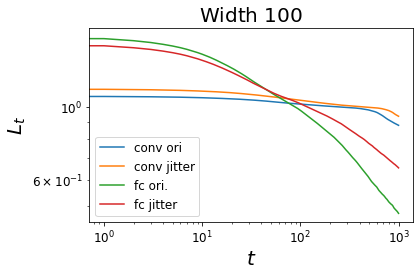

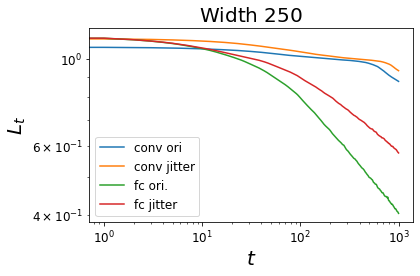

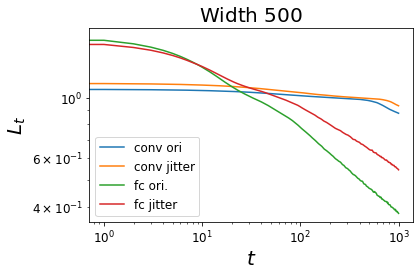

In [ ]:
for i, w in enumerate(widths):
  plt.loglog(all_conv_non[i], label =  labels[0])
  plt.loglog(all_conv_jit[i], label = labels[1])
  plt.loglog(all_fc_non[i], label = labels[2])
  plt.loglog(all_fc_jit[i], label = labels[3])
  plt.xlabel(r'$t$',fontsize=20)
  plt.ylabel(r'$L_t$',fontsize=20)
  plt.title(r'Width $%d$' % w, fontsize=20)
  plt.legend()
  plt.tight_layout()
  #plt.savefig(root_dir + 'jittered_image_conv_vs_fc_width_%d.pdf' % w)
  plt.show()

### Old code: disregard

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:4188: UserWarning: 'kind' argument to argsort is ignored.
  warnings.warn("'kind' argument to argsort is ignored.")


[[ 2.6673913 -1.3566117]
 [-1.3566117  1.0000999]]
[[ 1.6095911 -1.2679296]
 [-1.2679296  1.0010113]]


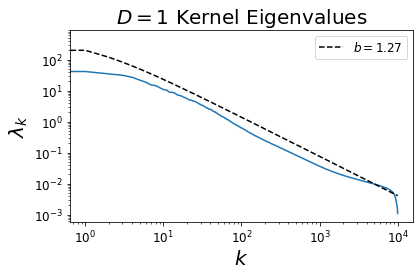

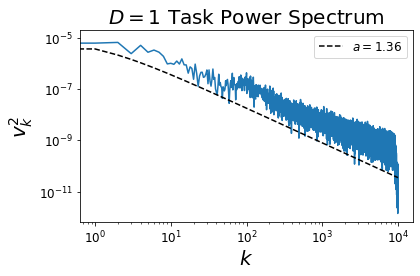

In [ ]:
width = 5000
depth = 1
init_fn, apply_fn, kernel_fn = fully_connected(width, depth)

X = X[0:10000,:]
K = kernel_fn(X, None, 'ntk')

eigs, vec = jnp.linalg.eigh(K)

y_mat = np.eye(10)[y[0:K.shape[0]]]

v = np.sum( ( 1/vec.shape[0] * vec.T @ y_mat)**2 , axis = 1)
indsort = np.argsort(eigs)[::-1]


eigs = eigs[indsort]
v = v[indsort]

b = jnp.cov(np.log(eigs[10:1000]), jnp.log(jnp.linspace(10,1000,1000-10)) ) / jnp.var(jnp.log(jnp.linspace(10,1000,1000-10)))
a = jnp.cov(np.log(v[10:]), jnp.log(jnp.linspace(11,len(eigs),len(eigs)-10)) ) / jnp.var(np.log(jnp.linspace(11,len(eigs),len(eigs)-10) ) )
print(a)
print(b)

plt.loglog(eigs.sort()[::-1])
plt.loglog( eigs[0] * jnp.linspace(1,len(eigs), len(eigs))**(b[0,1]) , '--', color = 'black', label = r'$b=%0.2f$' % (-1*b[0,1]))
plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$\lambda_k$',fontsize =20)
plt.title(r'$D=1$ Kernel Eigenvalues', fontsize = 20)
plt.legend()
plt.tight_layout()

plt.savefig(root_dir + 'mnist_spectra_scaling_exponent.pdf')
plt.show()

plt.loglog(v)
plt.loglog( v[0] * jnp.linspace(1,len(eigs), len(eigs))**(a[0,1]), '--', color = 'black' , label = r'$a=%0.2f$' % (-1*a[0,1]))
plt.xlabel(r'$k$',fontsize = 20)
plt.ylabel(r'$v_k^2$',fontsize =20)
plt.title(r'$D=1$ Task Power Spectrum', fontsize= 20)
plt.legend()
plt.tight_layout()

plt.savefig(root_dir + 'mnist_task_scaling_exponent.pdf')
plt.show()

0.13208906
0.12727162
0.12305632
0.1193636
0.116123974
0.113277756
0.11077334
0.108565986
0.106616914
0.10489225
0.10336266
0.102002844
0.10079092
0.099707656
0.09873649
0.09786289
0.09707432
0.096359886
0.095710054
0.095116645
0.09457246
0.09407126
0.09360761
0.09317675
0.09277464
0.09239765
0.09204271
0.09170711
0.09138847
0.09108478
0.09079424
0.09051531
0.09024661
0.08998702
0.08973546
0.08949108
0.08925308
0.089020796
0.08879361
0.08857103
0.08835258
0.088137895
0.08792661
0.087718464
0.08751317
0.08731049
0.08711022
0.08691221
0.08671632
0.08652238
0.086330295
0.086139955
0.085951254
0.085764125
0.0855785
0.0853943
0.085211486
0.08503001
0.08484983
0.08467091
0.08449321
0.0843167
0.08414135
0.08396713
0.08379402
0.083621986
0.08345101
0.08328108
0.0831122
0.082944356
0.08277752
0.08261167
0.08244681
0.08228292
0.082119994
0.081958
0.081796944
0.08163682
0.08147762
0.08131931
0.0811619
0.08100538
0.08084977
0.08069504
0.08054118
0.080388166
0.08023603
0.080084756
0.07993432
0.0797

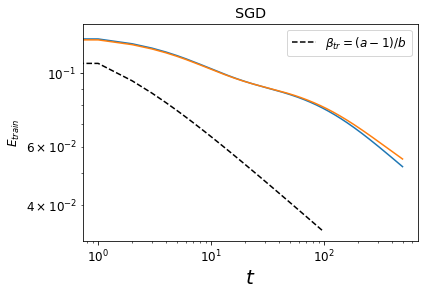

In [ ]:
_, params = init_fn(random.PRNGKey(0), (-1,784))

loss = jit( lambda params: jnp.mean(  ( apply_fn(params, X[0:2000,:]) - y_mat[0:2000,:])**2  ) )
test_loss = jit( lambda params: jnp.mean( ( apply_fn(params, X[2000:4000,:]) - y_mat[2000:4000,:])**2  ) )
grad_fn  = jit(grad(loss))
opt_init, opt_update, get_params = optimizers.sgd(10)
opt_state = opt_init(params)


losses = []
test = [ ]
for t in range(500):
  opt_state = opt_update(t, grad_fn(get_params(opt_state)) , opt_state)
  losses += [loss(get_params(opt_state))]
  print(loss(get_params(opt_state)), end = '\r')
  test += [test_loss(get_params(opt_state))]
plt.title('SGD', fontsize = 20)
plt.loglog(losses)
plt.loglog(test)
plt.loglog(losses[0] * jnp.linspace(1,100,100)**( -0.3 ), '--', color ='black',  label = r'$\beta_{tr} = (a-1)/b$')
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$L$', fontsize= 20)
plt.legend()
plt.tight_layout()
plt.show()

0.10305162
0.08848535
0.08613402
0.08593618
0.08246755
0.07573562
0.06792607
0.061207846
0.05681865
0.05480338
0.054217376
0.053756144
0.052500304
0.050290067
0.047589142
0.045084026
0.04329354
0.0423293
0.04189363
0.041490745
0.040723022
0.039487652
0.037977237
0.036522046
0.035391837
0.034662567
0.034203187
0.03377825
0.033195954
0.032409955
0.031522926
0.030699285
0.030056734
0.029599776
0.029231548
0.028826727
0.028312933
0.02770764
0.027092157
0.02654985
0.026112914
0.025747774
0.025387267
0.024981188
0.024527228
0.024066346
0.023646284
0.023286074
0.022966256
0.022647774
0.022302935
0.02193387
0.021566039
0.021225162
0.020917153
0.020627039
0.020333463
0.02002641
0.019713977
0.019412795
0.019132987
0.018870642
0.018613061
0.018350488
0.018083913
0.017821983
0.01757222
0.017334245
0.017101418
0.016867336
0.016631618
0.016399309
0.01617541
0.015960043
0.01574909
0.01553872
0.015328979
0.015122814
0.014922745
0.014728367
0.014537103
0.014346991
0.014158543
0.013973634
0.013793495
0.

0.00014249377
0.00014107804


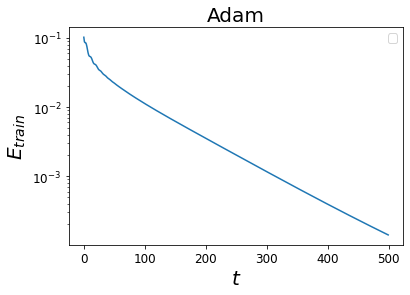

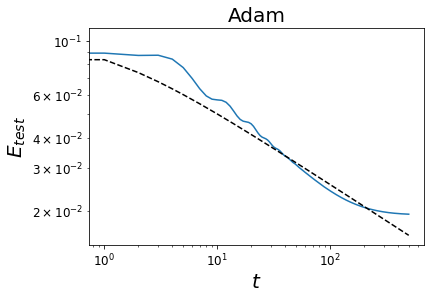

In [ ]:
import sys


opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(params)

losses = []
test = []
for t in range(500):
  opt_state = opt_update(t, grad_fn(get_params(opt_state)) , opt_state)
  losses += [loss(get_params(opt_state))]
  #sys.stdout(loss(get_params(opt_state)))
  print(loss(get_params(opt_state)))
  test += [test_loss(get_params(opt_state))]

plt.semilogy(losses)
#plt.semilogy(losses[0] * jnp.linspace(1,100,100)**(- 0.1 ), '--', color ='black',  label = r'$(a-1)/b$')
plt.title('Adam', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$E_{train}$', fontsize = 20)
plt.legend()
plt.show()

plt.loglog(test)
plt.title('Adam', fontsize= 20)
plt.xlabel(r'$t$', fontsize = 20)
plt.ylabel(r'$E_{test}$', fontsize = 20)
plt.loglog(test[0] * jnp.linspace(1, len(test), len(test))**(-0.3), '--', color = 'black')
plt.show()